In [26]:
import ppuu.lightning_modules
import imp
imp.reload(ppuu.lightning_modules)
from ppuu.lightning_modules import MPURKMSplitModule as Module

In [27]:
from ppuu.train_policy import main

In [28]:
import random

config = Module.Config()
config.model_config.model_type = 'km_split'
config.training_config.set_dataset('50')
config.training_config.epoch_size = 10
config.training_config.n_epochs = 0
config.training_config.seed = random.randint(0, 1000)
config.training_config.batch_size = 1
config.training_config.validation_size = 10
config.training_config.output_dir = '/home/us441/vlad/garbage'
config.cost_config.uncertainty_n_batches = 10 
model = main(config)

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | forward_model | ForwardModelKM      | 15 M  
1 | policy_model  | DeterministicPolicy | 6 M   
INFO:lightning:
  | Name          | Type                | Params
------------------------------------------------------
0 | forward_model | ForwardModelKM      | 15 M  
1 | policy_model  | DeterministicPolicy | 6 M   


[estimating normal uncertainty ranges: 100.0%]



In [29]:
import torch
from ppuu.dataloader import Dataset, DataStore
from torch.utils.data import DataLoader

ds_path = "/misc/vlgscratch4/LecunGroup/nvidia-collab/vlad/traffic-data_offroad_50_test_train_same/state-action-cost/data_i80_v0/"
data_store = DataStore(ds_path)

dataset = Dataset(
    data_store, "train", 20, 30, size=100, normalize=False
)

loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=0,
)

batch = next(iter(loader))
for k in batch:
    if torch.is_tensor(batch[k]):
        batch[k] = batch[k].cuda()

In [30]:
res = model.forward(batch)

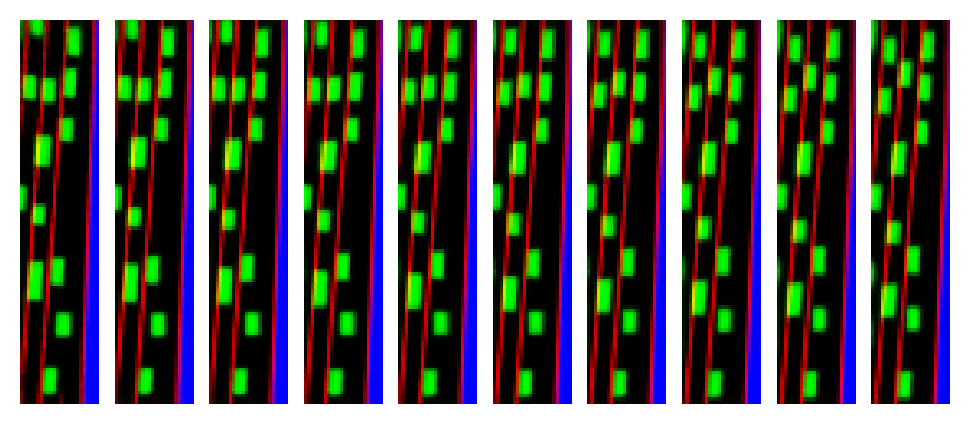

In [29]:
import numpy as np
from matplotlib import pyplot as plt

def plot_images(images):
    images = images.detach().cpu().numpy()
    f, axs = plt.subplots(1, 10, dpi=200)
    for i in range(10):
        image = np.transpose(images[0][i * 3], (1, 2, 0))
        axs[i].imshow(image)
        axs[i].set_axis_off()
plot_images(res['pred_images'])

In [9]:
predictions = model.forward_model.unfold(model.policy_model, batch)
predictions_km = model.forward_model.unfold_km(model.policy_model, batch)

In [10]:
true_predictions_vanilla = model.forward_model.unfold(batch['actions'], batch, Z=predictions_km['Z'])
true_predictions_km = model.forward_model.unfold_km(batch['actions'], batch, Z=predictions_km['Z'])

In [13]:
print((predictions['pred_states'] - batch['target_states']).norm())
print((predictions_km['pred_states']['km'] - batch['target_states']).norm())
print((true_predictions_vanilla['pred_states'] - batch['target_states']).norm())
print((true_predictions_km['pred_states']['km'] - batch['target_states']).norm())

tensor(2.9385, device='cuda:0', grad_fn=<NormBackward0>)
tensor(3.4453, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.3148, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.6513, device='cuda:0')


In [14]:
(true_predictions_vanilla['pred_states'] - batch['target_states']).abs() - (true_predictions_km['pred_states']['km'] - batch['target_states']).abs()

tensor([[[ 8.5419e-04,  1.1158e-04, -1.3231e-03, -1.3559e-02],
         [ 1.1711e-03,  8.7529e-04, -2.6078e-03,  3.6002e-03],
         [ 1.6218e-03,  1.4659e-03, -4.3522e-03,  5.6785e-04],
         [ 1.9503e-03,  2.1520e-03, -5.2023e-03, -1.5464e-02],
         [ 2.2746e-03,  3.0527e-03, -3.0237e-03,  4.0502e-02],
         [ 2.2353e-03,  3.2301e-03,  6.7050e-03,  2.5234e-02],
         [ 2.3696e-03,  3.3395e-03,  7.6664e-04, -1.0407e-02],
         [ 2.6741e-03,  3.8896e-03,  5.0592e-03,  3.3948e-02],
         [ 3.0683e-03,  4.6473e-03,  1.1976e-03,  1.0826e-01],
         [ 3.0780e-03,  3.7034e-03,  1.0811e-02, -5.4123e-01],
         [ 3.3867e-03,  4.4751e-03,  3.8002e-03, -1.1726e-01],
         [ 4.2456e-03,  5.3250e-03,  5.4813e-03, -7.5714e-03],
         [ 4.6727e-03,  5.1057e-03, -4.8123e-03,  2.4914e-02],
         [ 4.3551e-03,  4.8810e-03, -1.0437e-02,  2.3902e-02],
         [ 4.0969e-03,  4.6777e-03, -1.0965e-02,  3.4039e-02],
         [ 3.8094e-03,  4.5671e-03, -7.2924e-03,  3.387

In [15]:
batch['input_states']

tensor([[[-0.6091,  0.6450, -0.2801,  0.2769],
         [-0.6016,  0.6451, -0.2768,  0.2781],
         [-0.5940,  0.6453, -0.2762,  0.2769],
         [-0.5865,  0.6454, -0.2760,  0.2757],
         [-0.5789,  0.6456, -0.2760,  0.2745],
         [-0.5714,  0.6457, -0.2760,  0.2745],
         [-0.5638,  0.6458, -0.2761,  0.2745],
         [-0.5563,  0.6460, -0.2761,  0.2721],
         [-0.5487,  0.6461, -0.2762,  0.2733],
         [-0.5412,  0.6463, -0.2757,  0.2721],
         [-0.5336,  0.6464, -0.2761,  0.2709],
         [-0.5261,  0.6465, -0.2778,  0.2709],
         [-0.5185,  0.6467, -0.2784,  0.3933],
         [-0.5110,  0.6471, -0.2771,  0.4811],
         [-0.5034,  0.6478, -0.2745, -0.1117],
         [-0.4959,  0.6469, -0.2979, -0.2697],
         [-0.4885,  0.6457, -0.2926, -0.3383],
         [-0.4810,  0.6444, -0.2596, -0.3252],
         [-0.4733,  0.6430, -0.2446, -0.3335],
         [-0.4656,  0.6416, -0.2344, -0.3432]]], device='cuda:0')

In [16]:
#true_predictions_km['pred_states']['km'] - 
batch['target_states']

tensor([[[-0.4578,  0.6402, -0.2166, -0.3360],
         [-0.4499,  0.6389, -0.1929, -0.3384],
         [-0.4418,  0.6375, -0.1671, -0.3372],
         [-0.4336,  0.6361, -0.1264, -0.3264],
         [-0.4251,  0.6348, -0.1105, -0.3396],
         [-0.4165,  0.6334, -0.1024, -0.3504],
         [-0.4078,  0.6320, -0.0843, -0.3432],
         [-0.3991,  0.6306, -0.0449, -0.4548],
         [-0.3901,  0.6289, -0.0350, -0.5546],
         [-0.3811,  0.6270, -0.0108,  0.0359],
         [-0.3718,  0.6265,  0.0169,  0.1926],
         [-0.3625,  0.6265,  0.0180,  0.2504],
         [-0.3531,  0.6266,  0.0188,  0.2517],
         [-0.3437,  0.6267,  0.0183,  0.2541],
         [-0.3343,  0.6267,  0.0165,  0.2529],
         [-0.3249,  0.6268,  0.0158,  0.2529],
         [-0.3156,  0.6269,  0.0312,  0.2661],
         [-0.3061,  0.6270,  0.0166,  0.2529],
         [-0.2967,  0.6271,  0.0029,  0.2385],
         [-0.2874,  0.6272, -0.0077,  0.2505],
         [-0.2782,  0.6273,  0.0047,  0.2601],
         [-0.

In [17]:
true_predictions_km['pred_states']['km']

tensor([[[-4.5778e-01,  6.4025e-01, -2.2416e-01, -3.5289e-01],
         [-4.4991e-01,  6.3883e-01, -2.0632e-01, -3.4555e-01],
         [-4.4192e-01,  6.3743e-01, -1.8266e-01, -3.4793e-01],
         [-4.3378e-01,  6.3603e-01, -1.5680e-01, -3.4667e-01],
         [-4.2549e-01,  6.3463e-01, -1.1605e-01, -3.3564e-01],
         [-4.1694e-01,  6.3326e-01, -1.0016e-01, -3.4899e-01],
         [-4.0829e-01,  6.3185e-01, -9.2074e-02, -3.5994e-01],
         [-3.9959e-01,  6.3041e-01, -7.3913e-02, -3.5263e-01],
         [-3.9077e-01,  6.2900e-01, -3.4467e-02, -4.6575e-01],
         [-3.8172e-01,  6.2730e-01, -2.4553e-02, -5.6681e-01],
         [-3.7259e-01,  6.2535e-01, -2.9400e-04,  3.1511e-02],
         [-3.6332e-01,  6.2489e-01,  2.7407e-02,  1.9031e-01],
         [-3.5388e-01,  6.2483e-01,  2.8538e-02,  2.4884e-01],
         [-3.4443e-01,  6.2491e-01,  2.9293e-02,  2.5011e-01],
         [-3.3497e-01,  6.2499e-01,  2.8808e-02,  2.5255e-01],
         [-3.2552e-01,  6.2508e-01,  2.7029e-02,  2.513

In [18]:
batch['actions']

tensor([[[ 0.4479,  0.0419],
         [ 0.8129, -0.0679],
         [ 1.0935, -0.0273],
         [ 1.1998, -0.0479],
         [ 1.9154, -0.1194],
         [ 0.7204,  0.0453],
         [ 0.3441,  0.0479],
         [ 0.8286, -0.0508],
         [ 1.8582,  0.4213],
         [ 0.4367,  0.4042],
         [ 1.1035, -2.4048],
         [ 1.2872, -0.6063],
         [ 0.0091, -0.2057],
         [-0.0091,  0.0092],
         [-0.0688,  0.0047],
         [-0.1311,  0.0182],
         [-0.0818,  0.0138],
         [ 0.6967, -0.0345],
         [-0.7461,  0.0618],
         [-0.7097,  0.0679],
         [-0.5540, -0.0335],
         [ 0.5540, -0.0225],
         [-0.8524,  0.0448],
         [-0.8005,  0.0508],
         [-0.4165, -0.0451],
         [-1.0315,  0.0314],
         [ 1.3999, -0.0621],
         [ 0.1310, -0.0146],
         [-0.3569,  0.0707],
         [ 0.2245, -0.0579]]], device='cuda:0')

In [12]:
stats_empty = dict(
    s_mean=torch.zeros(1, 4),
    s_std=torch.ones(1, 4),
    a_mean=torch.zeros(1, 2),
    a_std=torch.ones(1, 2),
)
states = torch.tensor([[0.0, 0.0, 1.0, 1.0]]).cuda()
actions = torch.tensor([[10.0, 0.0]]).cuda()
pred_states = model.forward_model.predict_states(states, actions, batch['stats'])

In [13]:
batch['target_states'][:, 0].shape

torch.Size([1, 4])

In [14]:
def predict_states(states, actions, stats, timestep=0.1):
    states = states.clone()
    actions = actions.clone()

    ss_std = (
        stats["s_std"][0].view(1, 4).expand(states.size())
    ).cuda()
    ss_mean = stats["s_mean"][0].view(1, 4).expand(states.size()).cuda()
    aa_std = (stats["a_std"][0].view(1, 2)).cuda()
    aa_mean = stats["a_mean"][0].view(1, 2).cuda()

    actions = actions * aa_std + aa_mean
    states = states * ss_std + ss_mean

    a = actions[:, 0]
    b = actions[:, 1]

    positions = states[:, :2]
    speeds = states[:, 2:]
    speeds_norm = (speeds.norm(dim=1).view(speeds.shape[0], 1))

    directions_with_negative = speeds / speeds_norm
#     directions = torch.stack(
#         [
#             torch.abs(directions_with_negative[:, 0]),
#             directions_with_negative[:, 1],
#         ],
#         axis=1,
#     )
    directions = directions_with_negative

    new_positions = positions + timestep * speeds_norm * directions

    ortho_directions = torch.stack(
        [directions[:, 1], -directions[:, 0]], axis=1
    )

    new_directions_unnormed = (
        directions
        + ortho_directions * b.unsqueeze(1) * (speeds_norm * timestep + 1e-6)
    )
    new_directions = new_directions_unnormed / (
        new_directions_unnormed.norm(dim=1).view(speeds.shape[0], 1)
    )

    new_speeds_norm = speeds_norm + a.unsqueeze(1) * timestep
    new_speeds = new_directions * new_speeds_norm
#     new_speeds = new_directions * new_speeds_norm

    new_states = torch.cat([new_positions, new_speeds], 1)
    new_states = new_states - ss_mean
    new_states = new_states / ss_std

    return new_states

In [15]:
batch.keys()

dict_keys(['input_images', 'input_states', 'ego_cars', 'actions', 'target_images', 'target_states', 'target_costs', 'ids', 'car_sizes', 'stats'])

In [25]:
k = 0
if k >= 0:
    states = batch['target_states'][:, k]
else:
    states = batch['input_states'][-1]
print(states)
actions = batch['actions'][:, k + 1].clone()
breakpoint()
stats = batch['stats'].copy()
true_states = batch['target_states'][:, k + 1].clone()

# ss_std = (
#     1e-8 + stats["s_std"][0].view(1, 4).expand(states.size())
# ).cuda()
# ss_mean = stats["s_mean"][0].view(1, 4).expand(states.size()).cuda()
# aa_std = (1e-8 + stats["a_std"][0].view(1, 2)).cuda()
# aa_mean = stats["a_mean"][0].view(1, 2).cuda()

# actions = actions * aa_std + aa_mean
# states = states * ss_std + ss_mean
# true_states = true_states * ss_std + ss_mean

pred_states = predict_states(states, actions, stats_empty)

tensor([[ 1.2856e+03,  6.8445e+01,  9.1100e+01, -5.0276e-01]], device='cuda:0')
--Return--
> <ipython-input-25-8e81cb084bcc>(8)<module>()->None
-> breakpoint()
(Pdb) q


BdbQuit: 

In [17]:
batch['actions'].shape

torch.Size([1, 30, 2])

In [22]:
actions.shape

torch.Size([1, 2])

In [21]:
print(states.shape)
print('old states norm', states[0, 2:].norm())
print('naive pred norm', states[0, 2:].norm() + (actions[0, 0] * 0.1326))
print('true timestep', (true_states[0, 2:].norm() - states[0:, 2:].norm()) / actions[0, 0])
print('true pred norm', true_states[0, 2:].norm())
print('states', states)
print('actions', actions)
print('diff in pred', pred_states - true_states)
print('pred_states', pred_states)
print('true_states', true_states)

torch.Size([1, 4])
old states norm tensor(91.1011, device='cuda:0')
naive pred norm tensor(92.1982, device='cuda:0')
true timestep tensor(0.0861, device='cuda:0')
true pred norm tensor(91.8139, device='cuda:0')
states tensor([[ 1.2856e+03,  6.8445e+01,  9.1100e+01, -5.0276e-01]], device='cuda:0')
actions tensor([[8.2741e+00, 2.8007e-04]], device='cuda:0')
diff in pred tensor([[0.0000, 0.0000, 0.1148, 0.0189]], device='cuda:0')
pred_states tensor([[ 1.2947e+03,  6.8395e+01,  9.1926e+01, -7.4188e-01]], device='cuda:0')
true_states tensor([[ 1.2947e+03,  6.8395e+01,  9.1811e+01, -7.6082e-01]], device='cuda:0')


In [20]:
def analyze_batch(batch):
    states = batch['target_states']
    actions = batch['actions'][:, 1:]
    print(states.shape, actions.shape)
    stats = batch['stats']
    ss_std = (
        1e-8 + stats["s_std"][0].view(1, 4).expand(states.size())
    ).cuda()
    ss_mean = stats["s_mean"][0].view(1, 4).expand(states.size()).cuda()
    aa_std = (1e-8 + stats["a_std"][0].view(1, 2)).cuda()
    aa_mean = stats["a_mean"][0].view(1, 2).cuda()
    
    u_actions = actions * aa_std + aa_mean
    u_states = states * ss_std + ss_mean
    
    speed_norms = u_states[:, :, 2:].norm(dim=2)
    print(speed_norms.shape)
    diffs = speed_norms[:, 1:] - speed_norms[:, :-1]
    print(diffs.shape)
    print(u_actions[:, :, 0].shape)
    print(diffs)
    timesteps = diffs / u_actions[:, :, 0]
    print(timesteps.min(), timesteps.max())
    print(timesteps)
    
analyze_batch(batch)

torch.Size([1, 30, 4]) torch.Size([1, 29, 2])
torch.Size([1, 30])
torch.Size([1, 29])
torch.Size([1, 29])
tensor([[17.3909, 16.5854, 17.4551, 17.9060, 17.5518, 16.3279, 15.9092, 16.7141,
         16.5857, 14.7500,  9.8545,  6.1191,  1.7710,  0.2898,  0.0964,  0.1611,
         -0.3220, -0.2576, -0.3220, -0.8696, -0.0645,  4.3157,  9.2427, 14.0413,
         18.8076, 23.6387, 24.9587, 23.5095, 19.0332]], device='cuda:0')
tensor(-0.6303, device='cuda:0') tensor(43.1754, device='cuda:0')
tensor([[ 4.1152e-01,  4.5470e-01,  5.0206e-01,  4.8996e-01,  4.6884e-01,
          4.4468e-01,  4.6553e-01,  5.0187e-01,  4.7418e-01,  4.2495e-01,
          3.1896e-01,  2.9531e-01,  1.3671e-01,  7.4452e-02,  1.2524e-01,
          4.5047e-01, -6.3026e-01,  5.8168e-01,  1.0952e+00,  1.9823e+00,
          4.0981e-02,  4.3175e+01,  1.0034e+00,  7.2136e-01,  6.3871e-01,
          6.0059e-01,  5.0523e-01,  4.5087e-01,  3.8735e-01]], device='cuda:0')
